### Figure: Role of the open ocean in setting inter-annual variability

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram as hist

In [6]:
# Universal variables
rootdir = 'data/'
yrst = 1958
yrinit = 1976
yrend = 2016
years = np.arange(yrst,yrend+1,1)
years_c = 0.5*(years[:-1]+years[1:])
years_init = np.arange(yrinit,yrend+1,1)
years_init_c = 0.5*(years_init[:-1]+years_init[1:])
bathys = np.array([1,40,51,60,65,76])

In [3]:
# Load bathymetry
filepath_zgrid = rootdir+'raw/mesh_zgr.nc'
zgrid = xr.open_dataset(filepath_zgrid).squeeze()
# Load volumetric distribution of subduction location and age from ariane output
filepath_vlag = rootdir+'processed/lagrangian/D4_weights-init_volume_bins-final_x-final_y-final_age-init_t_subset-final_section-7.nc'
vlag = xr.open_dataarray(filepath_vlag)
# Get the Lagrangian data and the grid data on the same grid
# Assign coordinates
zgrid = zgrid.assign_coords({'x':range(1,zgrid.x.size+1),'y':range(1,zgrid.y.size+1)})
# Subset grid to region_limits
xmask = (zgrid.x>=np.floor(vlag.final_x_bin.min())) & (zgrid.x<np.ceil(vlag.final_x_bin.max()))
ymask = (zgrid.y>=np.floor(vlag.final_y_bin.min())) & (zgrid.y<np.ceil(vlag.final_y_bin.max()))
zgrid = zgrid.where(xmask & ymask,drop=True)
# Make consistent with lagrangian output
zgrid = zgrid.rename({'x':'final_x_bin','y':'final_y_bin'})
zgrid = zgrid.assign_coords({'final_x_bin':vlag.final_x_bin,'final_y_bin':vlag.final_y_bin})
# Propoagate bathymetry data across time and merge datasets
zgrid['mbathy'] = zgrid.mbathy*xr.ones_like(vlag)
vlag = xr.merge([vlag,zgrid.mbathy])

In [7]:
# PROCESS LAGRANGIAN DATA
# Histogram the distribution according to the bathymetry of the subduction location
vlag_bathy = hist(vlag.mbathy,
                  bins=[bathys],
                  dim=['final_x_bin','final_y_bin'],
                  weights=vlag.init_volume)

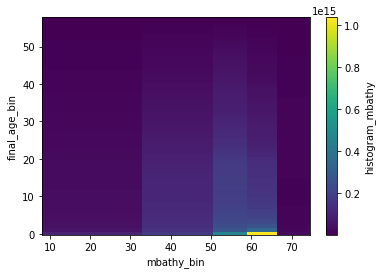

In [8]:
vlag_bathy.mean('init_t_bin').plot()